In [3]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-english.csv'

# Read the CSV file
df = pd.read_csv(file_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval



df["ada_embedding_eng"] = df["ada_embedding_eng"].apply(literal_eval).apply(np.array)

x = df["ada_embedding_eng"]
y = df['numerical_price']
# Explode the embedding arrays into separate columns



AttributeError: 'list' object has no attribute 'sample'

In [5]:
x = x.apply(pd.Series)

# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]

In [6]:

!pip install optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_nn(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=False)
    neurons_layer_1 = trial.suggest_int("neurons_layer_1", 16, 1024, step=16)
    neurons_layer_2 = trial.suggest_int("neurons_layer_2", 16, 512, step=16)
    neurons_layer_3 = trial.suggest_int("neurons_layer_3", 16, 256, step=16)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 100)
    regularization = trial.suggest_categorical("regularization", ["none", "l1", "l2", "l1_l2"])
    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-1, log=True) if regularization in ["l1", "l1_l2"] else 0
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True) if regularization in ["l2", "l1_l2"] else 0

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]



        # Build model
        model = Sequential()
        model.add(Dense(neurons_layer_1, activation='relu', input_shape=(X_train_fold.shape[1],),
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_2, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_3, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Scaling y_train
        scaler = StandardScaler()
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Train model
        model.fit(X_train_fold, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred_scaled = model.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [7]:
import numpy as np

# Convert x_train and x_test to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)


print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)


x_train shape: (10000, 1536)
x_test shape: (14403, 1536)
y_train shape: (10000,)
y_test shape: (14403,)
Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)


In [8]:
study_svr = optuna.create_study(directions=['maximize'])
study_svr.optimize(Objective_nn, n_trials=50)

[I 2024-01-06 12:49:25,055] A new study created in memory with name: no-name-357e6aa9-d215-4e40-860f-deb76c43568a


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:51:27,435] Trial 0 finished with value: 0.5709212260271033 and parameters: {'learning_rate': 0.005301876041996502, 'neurons_layer_1': 544, 'neurons_layer_2': 432, 'neurons_layer_3': 144, 'batch_size': 64, 'epochs': 78, 'regularization': 'none'}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:52:29,912] Trial 1 finished with value: -0.0005984394712040597 and parameters: {'learning_rate': 0.009531965950361853, 'neurons_layer_1': 528, 'neurons_layer_2': 224, 'neurons_layer_3': 208, 'batch_size': 128, 'epochs': 63, 'regularization': 'l1', 'l1_reg': 0.005618093199467732}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:53:27,651] Trial 2 finished with value: -0.0012641929510345928 and parameters: {'learning_rate': 0.006786241203551261, 'neurons_layer_1': 624, 'neurons_layer_2': 256, 'neurons_layer_3': 48, 'batch_size': 16, 'epochs': 9, 'regularization': 'l2', 'l2_reg': 0.012915287564490039}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:01:04,543] Trial 3 finished with value: -0.0012500471781703658 and parameters: {'learning_rate': 0.006774413364414989, 'neurons_layer_1': 192, 'neurons_layer_2': 160, 'neurons_layer_3': 112, 'batch_size': 16, 'epochs': 78, 'regularization': 'l1_l2', 'l1_reg': 0.04718805969868985, 'l2_reg': 0.0014279285749004456}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:01:42,394] Trial 4 finished with value: 0.09214654249023213 and parameters: {'learning_rate': 0.005454414013639755, 'neurons_layer_1': 976, 'neurons_layer_2': 64, 'neurons_layer_3': 176, 'batch_size': 64, 'epochs': 20, 'regularization': 'l2', 'l2_reg': 0.004243566432965059}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 13:10:24,719] Trial 5 finished with value: 0.44577410566593245 and parameters: {'learning_rate': 0.008674134910911565, 'neurons_layer_1': 64, 'neurons_layer_2': 256, 'neurons_layer_3': 256, 'batch_size': 16, 'epochs': 91, 'regularization': 'l1', 'l1_reg': 4.272165834848994e-05}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:12:46,295] Trial 6 finished with value: -0.0018461349119538895 and parameters: {'learning_rate': 0.007752594582047387, 'neurons_layer_1': 528, 'neurons_layer_2': 368, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 23, 'regularization': 'l1_l2', 'l1_reg': 0.0002451397153607201, 'l2_reg': 0.0005176951419956067}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:18:01,118] Trial 7 finished with value: 0.4237044488237851 and parameters: {'learning_rate': 0.005632723156134478, 'neurons_layer_1': 16, 'neurons_layer_2': 288, 'neurons_layer_3': 48, 'batch_size': 16, 'epochs': 57, 'regularization': 'none'}. Best is trial 0 with value: 0.5709212260271033.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:22:46,687] Trial 8 finished with value: 0.5777316106736419 and parameters: {'learning_rate': 0.007876412039635048, 'neurons_layer_1': 432, 'neurons_layer_2': 192, 'neurons_layer_3': 144, 'batch_size': 16, 'epochs': 51, 'regularization': 'none'}. Best is trial 8 with value: 0.5777316106736419.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:25:21,125] Trial 9 finished with value: -0.00034950905641584207 and parameters: {'learning_rate': 0.007965649660547401, 'neurons_layer_1': 368, 'neurons_layer_2': 336, 'neurons_layer_3': 128, 'batch_size': 16, 'epochs': 26, 'regularization': 'l1', 'l1_reg': 0.07755667700511662}. Best is trial 8 with value: 0.5777316106736419.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:27:05,319] Trial 10 finished with value: 0.5842458402738475 and parameters: {'learning_rate': 0.0016465735057069027, 'neurons_layer_1': 768, 'neurons_layer_2': 32, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 35, 'regularization': 'none'}. Best is trial 10 with value: 0.5842458402738475.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:29:05,311] Trial 11 finished with value: 0.5970324986605648 and parameters: {'learning_rate': 0.0015640065767859258, 'neurons_layer_1': 784, 'neurons_layer_2': 32, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 41, 'regularization': 'none'}. Best is trial 11 with value: 0.5970324986605648.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:30:58,352] Trial 12 finished with value: 0.6108849074665503 and parameters: {'learning_rate': 0.0012157205772678431, 'neurons_layer_1': 800, 'neurons_layer_2': 16, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 38, 'regularization': 'none'}. Best is trial 12 with value: 0.6108849074665503.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:33:03,825] Trial 13 finished with value: 0.61314686779975 and parameters: {'learning_rate': 0.0008152339372851421, 'neurons_layer_1': 880, 'neurons_layer_2': 96, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 42, 'regularization': 'none'}. Best is trial 13 with value: 0.61314686779975.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:35:06,771] Trial 14 finished with value: 0.6203607772271791 and parameters: {'learning_rate': 0.0001907952213340274, 'neurons_layer_1': 960, 'neurons_layer_2': 112, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 42, 'regularization': 'none'}. Best is trial 14 with value: 0.6203607772271791.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:37:26,520] Trial 15 finished with value: 0.6042411691097243 and parameters: {'learning_rate': 0.0030347976538390564, 'neurons_layer_1': 1024, 'neurons_layer_2': 128, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 48, 'regularization': 'none'}. Best is trial 14 with value: 0.6203607772271791.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:40:37,090] Trial 16 finished with value: 0.6169829876834484 and parameters: {'learning_rate': 0.0002523299895961185, 'neurons_layer_1': 912, 'neurons_layer_2': 112, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 67, 'regularization': 'none'}. Best is trial 14 with value: 0.6203607772271791.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:41:43,674] Trial 17 finished with value: 0.592659730864426 and parameters: {'learning_rate': 0.003538290494371166, 'neurons_layer_1': 672, 'neurons_layer_2': 128, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 69, 'regularization': 'l2', 'l2_reg': 1.2634019073235722e-05}. Best is trial 14 with value: 0.6203607772271791.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 13:46:37,970] Trial 18 finished with value: -0.0009478506058916203 and parameters: {'learning_rate': 0.0031295551679926628, 'neurons_layer_1': 928, 'neurons_layer_2': 176, 'neurons_layer_3': 48, 'batch_size': 32, 'epochs': 97, 'regularization': 'l1_l2', 'l1_reg': 1.8275356347037107e-05, 'l2_reg': 0.07542316151707416}. Best is trial 14 with value: 0.6203607772271791.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:50:04,951] Trial 19 finished with value: 0.6139274193565825 and parameters: {'learning_rate': 0.00014835896634744002, 'neurons_layer_1': 880, 'neurons_layer_2': 512, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 72, 'regularization': 'none'}. Best is trial 14 with value: 0.6203607772271791.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:52:49,780] Trial 20 finished with value: 0.5829845912343007 and parameters: {'learning_rate': 0.004016546816101202, 'neurons_layer_1': 688, 'neurons_layer_2': 112, 'neurons_layer_3': 48, 'batch_size': 32, 'epochs': 57, 'regularization': 'none'}. Best is trial 14 with value: 0.6203607772271791.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:56:28,789] Trial 21 finished with value: 0.6281998237199552 and parameters: {'learning_rate': 0.00016275683513421806, 'neurons_layer_1': 896, 'neurons_layer_2': 512, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 77, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:00:30,411] Trial 22 finished with value: 0.5796248380483758 and parameters: {'learning_rate': 0.0022986225399605647, 'neurons_layer_1': 1024, 'neurons_layer_2': 448, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 85, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:03:41,344] Trial 23 finished with value: 0.6177875940136491 and parameters: {'learning_rate': 0.0007354962594476521, 'neurons_layer_1': 848, 'neurons_layer_2': 304, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 66, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:05:00,014] Trial 24 finished with value: 0.60545659995626 and parameters: {'learning_rate': 0.0019523952201491515, 'neurons_layer_1': 816, 'neurons_layer_2': 352, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 82, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:06:37,564] Trial 25 finished with value: 0.6080250862949754 and parameters: {'learning_rate': 0.0007746533936761466, 'neurons_layer_1': 848, 'neurons_layer_2': 496, 'neurons_layer_3': 112, 'batch_size': 64, 'epochs': 62, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:11:03,172] Trial 26 finished with value: -0.0006541583920747218 and parameters: {'learning_rate': 0.002465185903809936, 'neurons_layer_1': 720, 'neurons_layer_2': 304, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 88, 'regularization': 'l1_l2', 'l1_reg': 0.0017704546047202045, 'l2_reg': 2.1532663319228744e-05}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:14:43,139] Trial 27 finished with value: 0.1099227880262488 and parameters: {'learning_rate': 0.004438829604623509, 'neurons_layer_1': 960, 'neurons_layer_2': 416, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 74, 'regularization': 'l1', 'l1_reg': 0.00012812650071240703}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 14:19:29,946] Trial 28 finished with value: 0.5823802184370038 and parameters: {'learning_rate': 0.0009536722373985723, 'neurons_layer_1': 288, 'neurons_layer_2': 464, 'neurons_layer_3': 64, 'batch_size': 32, 'epochs': 99, 'regularization': 'l2', 'l2_reg': 0.0001438235272053717}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:20:22,141] Trial 29 finished with value: 0.5969141715552233 and parameters: {'learning_rate': 0.00036599064163371324, 'neurons_layer_1': 576, 'neurons_layer_2': 400, 'neurons_layer_3': 112, 'batch_size': 64, 'epochs': 31, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:22:39,143] Trial 30 finished with value: 0.6119153581360817 and parameters: {'learning_rate': 0.002499112163682224, 'neurons_layer_1': 720, 'neurons_layer_2': 208, 'neurons_layer_3': 64, 'batch_size': 32, 'epochs': 46, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:25:47,585] Trial 31 finished with value: 0.6160525005685992 and parameters: {'learning_rate': 0.0001746009393944048, 'neurons_layer_1': 912, 'neurons_layer_2': 64, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 65, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:28:32,583] Trial 32 finished with value: 0.6067038772291695 and parameters: {'learning_rate': 0.001272534526171498, 'neurons_layer_1': 960, 'neurons_layer_2': 160, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 57, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:29:46,338] Trial 33 finished with value: 0.6012688428214622 and parameters: {'learning_rate': 0.0006851766019878998, 'neurons_layer_1': 848, 'neurons_layer_2': 240, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 77, 'regularization': 'none'}. Best is trial 21 with value: 0.6281998237199552.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:32:56,559] Trial 34 finished with value: 0.6350217588166369 and parameters: {'learning_rate': 0.00014245324321009346, 'neurons_layer_1': 1008, 'neurons_layer_2': 288, 'neurons_layer_3': 240, 'batch_size': 32, 'epochs': 66, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:35:03,551] Trial 35 finished with value: -0.0008679585378271515 and parameters: {'learning_rate': 0.0018327645334581348, 'neurons_layer_1': 1024, 'neurons_layer_2': 304, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 81, 'regularization': 'l2', 'l2_reg': 0.06544129512922182}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:38:06,891] Trial 36 finished with value: -0.0017378101566706493 and parameters: {'learning_rate': 0.009795183426588559, 'neurons_layer_1': 624, 'neurons_layer_2': 384, 'neurons_layer_3': 224, 'batch_size': 32, 'epochs': 62, 'regularization': 'l1', 'l1_reg': 0.012619220026622779}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:38:25,777] Trial 37 finished with value: -0.0010115863499716936 and parameters: {'learning_rate': 0.006047877120175672, 'neurons_layer_1': 992, 'neurons_layer_2': 272, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 12, 'regularization': 'l1_l2', 'l1_reg': 0.0008935528704115688, 'l2_reg': 0.0001259752570737734}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:41:04,412] Trial 38 finished with value: 0.6033184856330026 and parameters: {'learning_rate': 0.0012449114899977136, 'neurons_layer_1': 944, 'neurons_layer_2': 320, 'neurons_layer_3': 160, 'batch_size': 32, 'epochs': 54, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:45:24,702] Trial 39 finished with value: 0.5746937438956646 and parameters: {'learning_rate': 0.004798351703652326, 'neurons_layer_1': 752, 'neurons_layer_2': 224, 'neurons_layer_3': 256, 'batch_size': 32, 'epochs': 91, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:47:17,079] Trial 40 finished with value: 0.588594784516267 and parameters: {'learning_rate': 0.0006547209565220162, 'neurons_layer_1': 864, 'neurons_layer_2': 480, 'neurons_layer_3': 208, 'batch_size': 64, 'epochs': 72, 'regularization': 'l1', 'l1_reg': 1.2360579023480274e-05}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:50:26,322] Trial 41 finished with value: 0.6270551283703194 and parameters: {'learning_rate': 0.00012476792686007677, 'neurons_layer_1': 944, 'neurons_layer_2': 80, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 67, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:54:08,072] Trial 42 finished with value: 0.6244761765901138 and parameters: {'learning_rate': 0.00014216867668666132, 'neurons_layer_1': 976, 'neurons_layer_2': 80, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 76, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:57:54,570] Trial 43 finished with value: 0.6273341393099988 and parameters: {'learning_rate': 0.00017133373658047873, 'neurons_layer_1': 992, 'neurons_layer_2': 64, 'neurons_layer_3': 48, 'batch_size': 32, 'epochs': 78, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 15:05:22,220] Trial 44 finished with value: 0.6204567115988198 and parameters: {'learning_rate': 0.001518005614903527, 'neurons_layer_1': 992, 'neurons_layer_2': 48, 'neurons_layer_3': 64, 'batch_size': 16, 'epochs': 78, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 15:09:18,132] Trial 45 finished with value: 0.6027042743720546 and parameters: {'learning_rate': 0.0020435117326025446, 'neurons_layer_1': 912, 'neurons_layer_2': 80, 'neurons_layer_3': 48, 'batch_size': 32, 'epochs': 76, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 15:13:42,170] Trial 46 finished with value: 0.21524548955255565 and parameters: {'learning_rate': 0.001192020295461517, 'neurons_layer_1': 464, 'neurons_layer_2': 16, 'neurons_layer_3': 96, 'batch_size': 32, 'epochs': 83, 'regularization': 'l2', 'l2_reg': 0.011825526237400939}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 15:17:24,280] Trial 47 finished with value: 0.632347487052404 and parameters: {'learning_rate': 0.00010301825165127948, 'neurons_layer_1': 992, 'neurons_layer_2': 160, 'neurons_layer_3': 176, 'batch_size': 32, 'epochs': 70, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 15:25:02,654] Trial 48 finished with value: -0.0008762982586660861 and parameters: {'learning_rate': 0.007114591255622358, 'neurons_layer_1': 176, 'neurons_layer_2': 144, 'neurons_layer_3': 160, 'batch_size': 16, 'epochs': 70, 'regularization': 'l1_l2', 'l1_reg': 0.00046783406625028155, 'l2_reg': 0.00010642825575951143}. Best is trial 34 with value: 0.6350217588166369.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 15:28:12,929] Trial 49 finished with value: 0.583278563584855 and parameters: {'learning_rate': 0.009169943822937099, 'neurons_layer_1': 1024, 'neurons_layer_2': 176, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 61, 'regularization': 'none'}. Best is trial 34 with value: 0.6350217588166369.


<ipython-input-9-b7f3a9c196e1>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

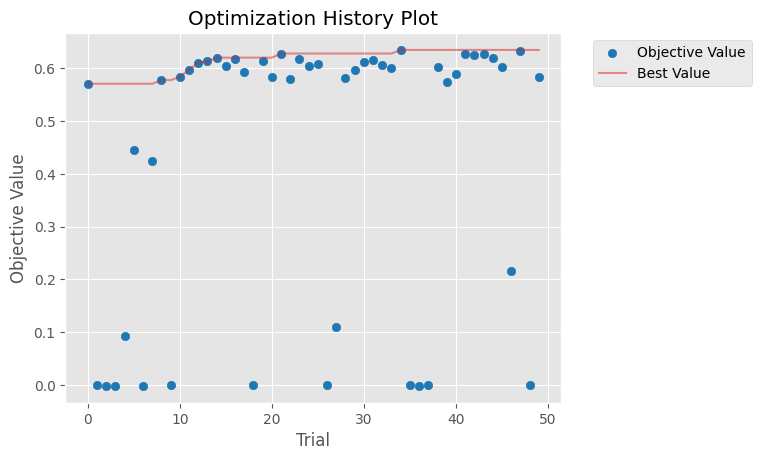

In [9]:
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

<ipython-input-10-62749383f84c>:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
<ipython-input-10-62749383f84c>:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
<ipython-input-10-62749383f84c>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_svr)


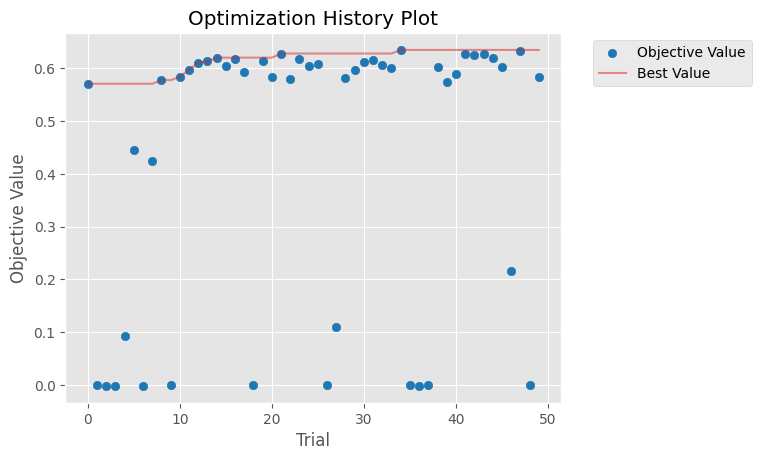

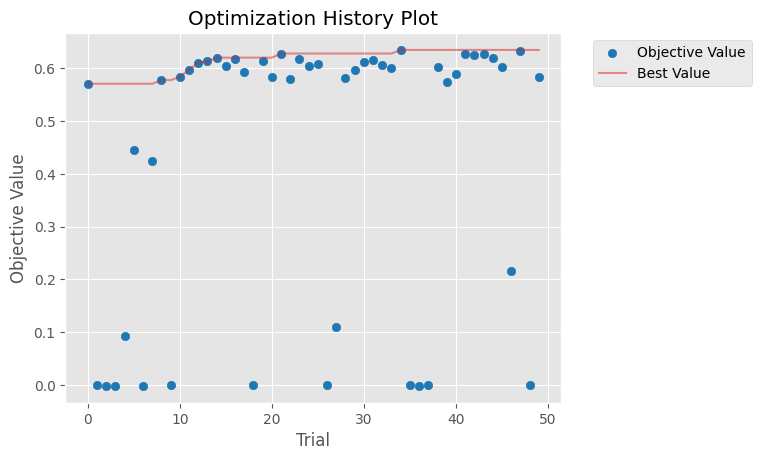

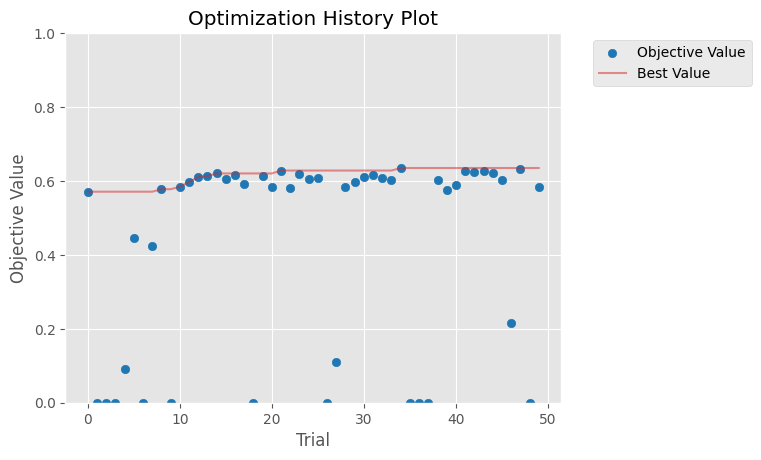

In [10]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna.visualization.matplotlib.plot_optimization_history(study_svr)
optuna_matplotlib.plot_optimization_history(study_svr)

plt.ylim(0, 1)

# Show the plot
plt.show()